## 계층적 클러스터링이란?
계층적 클러스터링(Hierachical Clustering)은 순차적으로 유사한 데이터끼리 같은 클러스터로 묶어 나가는 모델입니다.  
데이터를 아래에서부터 묶어 나간다고 해서 Bottom-Up 클러스터링이라고도 합니다.

계층적 클러스터링의 과정은 다음과 같습니다.

먼저, 각 데이터 사이의 거리를 모두 계산하여 가장 가까운 데이터 쌍을 차례대로 묶어갑니다.

묶인 데이터 쌍 끼리도 거리를 계산하여, 가까운 쌍은 하나로 묶습니다.  
모든 데이터가 하나의 클러스터로 묶일 때 까지 이 과정을 반복합니다.  

모든 클러스터의 계층이 구분되어 연결된 이 상태의 그래프를 덴드로그램(Dendrogram)이라고 합니다.  
계층적 클러스터링은 이 덴드로그램을 이용해 원하는 개수로 클러스터를 나눌 수 있습니다.

만약에 클러스터의 개수를 3개로 하고 싶다면 아래와 같이 구분하면 됩니다. 계층에 따라 ABCD / E / FGHI가  
하나의 클러스터로 묶였네요.

![image1](image/계층적%20클러스터링/15-4.png)

그렇다면, 계층을 묶을 때 특정 데이터가 서로 유사하다는 것은 어떻게 정의할 수 있을까요? 다양한 방법이 있는데요,  
대표적으로 Ward 거리라는 개념을 많이 사용합니다.

Ward 거리란 각 클러스터의 Center와 속한 데이터들 사이 거리를 제곱하여 더한 값의 증가분을 뜻합니다.

예를 들어, 위의 이미지에서 클러스터를 4개로 나눴을 때는 F, G, H와 I가 서로 다른 클러스터로 분류됐었죠?

이 상태에서 F, G, H 세 데이터의 중심점과 각 데이터 사이 거리의 제곱합이 있을텐데요.  
I까지 하나의 클러스터로 묶이게 되면 이 값이 조금 더 커질 것입니다. 이 두 값 사이의 차이(증가분)가 Ward 거리입니다.  
계층적 클러스터링은 이 값이 최대한 작게 증가되는 순서로 계층을 묶어 나갑니다.

## 계층적 클러스터링 실습

In [1]:
### 03. 데이터 준비하기.ipynb의 내용 (scaled_data 사용하기 위한 코드)
import pandas as pd
import seaborn as sns

# 판다스 출력 결과를 소수점 둘째 자리 까지로 제한
pd.options.display.float_format = '{:,.2f}'.format

sales_df = pd.read_csv('data/sales_data.csv', index_col=['customer_id'])
sales_df
# =====
# 이상치 제거 함수
def get_outlier_mask(df, weight=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 = Q1
    IQR_weight = IQR * weight

    range_min = Q1 - IQR_weight  # 정상범위의 최소값
    range_max = Q3 + IQR_weight  # 정상범위의 최대값

    outlier_per_column = (df < range_min) | (df > range_max)  # 최소값보다 작거나, 최대값보다 크면 이상치로 간주. 
                                                              # -> 불린값을 Pandas Series로 반환..할 듯
    
    is_outlier = outlier_per_column.any(axis=1)  # 각 행에 대하여 True 혹은 False 값을 가진 Pandas Series가 반환됨. (True이면 이상치.)

    return is_outlier
# =====
outlier_idx_cust_df = get_outlier_mask(sales_df, weight=1.5)  # True/False 값을 가진 Pandas Series가 반환됨.

# 아웃라이어 제거한 데이터 프레임만 추가
sales_df = sales_df[~outlier_idx_cust_df]
# =====
df_mean = sales_df.mean()  # 각 컬럼의 평균값
df_std = sales_df.std()  # 각 컬럼의 표준편차

scaled_df = (sales_df - df_mean) / df_std  # 컬럼별 표준화 진행 ~> 이게 왜 표준화가 되지?

# 컬럼명 설정.
scaled_df.columns = ['total_buy_cnt', 'total_price']

# 인덱스 설정
scaled_df.index = sales_df.index

scaled_df

,total_buy_cnt,total_price
customer_id,,
12471,-0.99,-0.66
12557,-0.40,-0.71
12600,-0.88,0.33
12686,1.74,0.57
12748,-0.74,-0.60
...,...,...
17949,-1.33,-0.45
17951,-0.03,0.50
18085,0.93,1.59


먼저, 계층적 클러스터링을 하기 위해 `scipy` 라이브러리를 불러옵니다.  
이후에 덴드로그램 시각화도 해야하니 `matplotlib`도 함께 불러올게요.

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import matplotlib.pyplot as plt

다음으로, 모델을 학습시켜 보겠습니다. 계층적 클러스터링에는 `linkage()` 함수가 사용됩니다.  
파라미터로 데이터와 어떠한 거리 메소드를 사용할지 지정해 줘야 합니다. 저희 실습에서는 Ward 거리를 사용해 볼게요.

In [3]:
# 거리 : ward method
model = linkage(scaled_df, 'ward')

학습된 결과를 덴드로그램으로 시각화하면 아래와 같습니다. 좀 더 잘 표현하기 위해 사이즈와 스타일도 일부 조정해 줄게요.

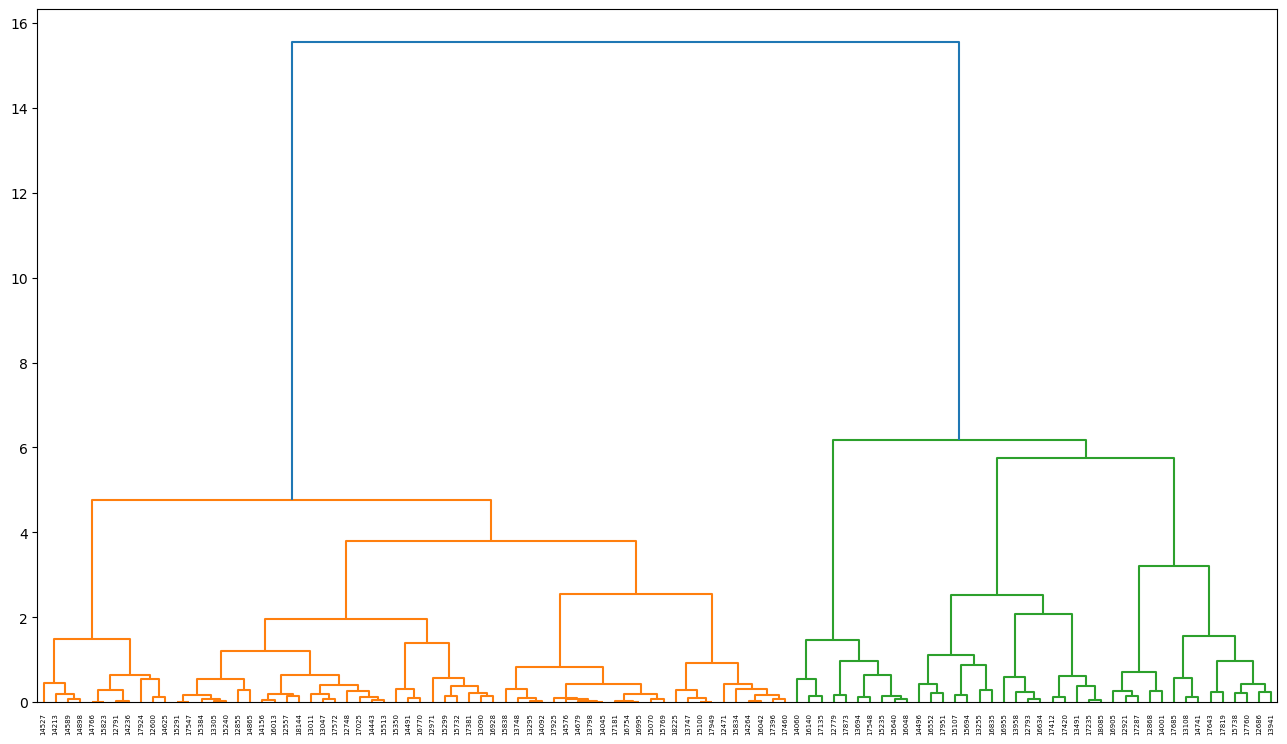

In [4]:
labelList = scaled_df.index

# 덴드로그램 사이즈와 스타일 조정
plt.figure(figsize=(16,9))
plt.style.use('default')

dendrogram(model, labels=labelList)
plt.show()

위 그래프를 바탕으로 클러스터를 5개로 나눠 보고, 각 클러스터별로 고객이 몇 명씩 속해 있는지 확인해 볼게요.

In [5]:
cluster_num = 5

# 고객별 클러스터 라벨 구하기
scaled_df['label'] = cut_tree(model, cluster_num)

pd.DataFrame(scaled_df['label'].value_counts())

,count
label,
0,51
4,16
2,14
1,11
3,10


앞서서 k-means로 클러스터링했을 때와 조금 다른 결과가 나온 것 같습니다. 확실한 비교를 위해 시각화해 보겠습니다.

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

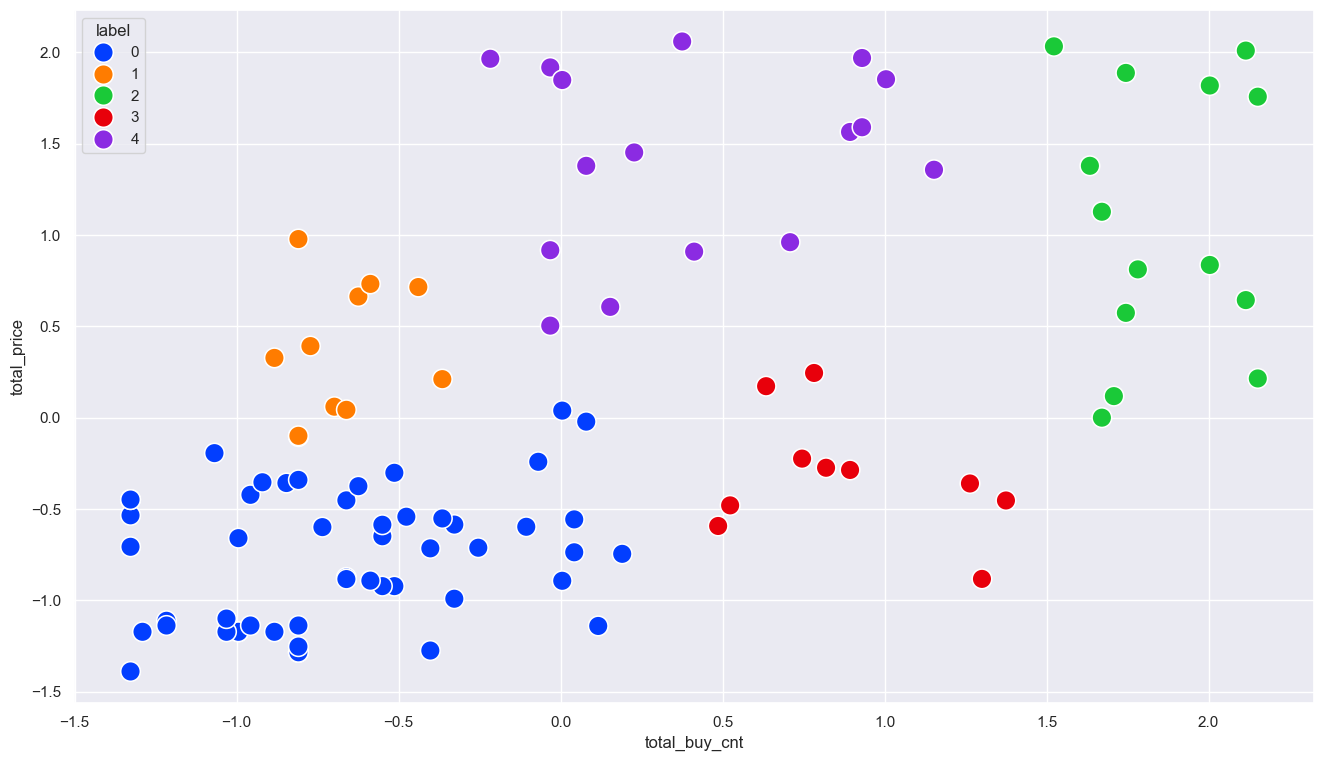

In [6]:
sns.set(style='darkgrid',
        rc={'figure.figsize':(16, 9)})

# 계층적 클러스터링
sns.scatterplot(x=scaled_df['total_buy_cnt'], y=scaled_df['total_price'], hue=scaled_df['label'], s=200, palette='bright')

## 계층적 클러스터링 장단점
계층적 클러스터링의 가장 큰 장점은 모델을 학습시킬 때 클러스터의 개수를 미리 가정하지 않아도 된다는 점입니다.

k-means는 사전에 정한 k값에 따라 결과가 달라졌지만, 계층적 클러스터링은 클러스트의 개수에 상관 없이 모델을 학습시킬 수 있습니다.

앞선 예시에서 봤듯이 덴드로그램의 어떤 계층에서 데이터를 구분해 주냐에 따라 클러스터의 개수가 조절됐었죠?  
때문에, 클러스터의 개수를 몇 개로 해야할 지 모를 때 유용하게 사용할 수 있습니다.

하지만, 계층적 클러스터링은 모든 데이터끼리의 거리를 반복해서 계산해야 하기 때문에 많은 연산이 필요합니다.  
예를 들어 천 개의 데이터를 가지고 있다면 그 제곱인 백 만번의 연산이 필요합니다. 때문에 학습 속도가 느리고,  
대용량 데이터에 적용이 어렵다는 단점이 있습니다.